# Process Data, Train, Test, and Evaluate Model

## Setup

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,  classification_report
import pickle
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import os

In [3]:
# global variables
seed = 83 # last 2 digits of student number
training_size = 0.7
testing_size = (1 - training_size) / 2 # 0.15
validation_size = testing_size # 0.15

## Data processing

In [4]:
# Load all the data
DATA_PATH = "raw_data"
acceleration_x = pd.read_csv(os.path.join(DATA_PATH, "acceleration_x.csv"))
acceleration_y = pd.read_csv(os.path.join(DATA_PATH, "acceleration_y.csv"))
acceleration_z = pd.read_csv(os.path.join(DATA_PATH, "acceleration_z.csv"))
gyroscope_x = pd.read_csv(os.path.join(DATA_PATH, "gyroscope_x.csv"))
gyroscope_y = pd.read_csv(os.path.join(DATA_PATH, "gyroscope_y.csv"))
gyroscope_z = pd.read_csv(os.path.join(DATA_PATH, "gyroscope_z.csv"))
labels = pd.read_csv(os.path.join(DATA_PATH, "labels.csv"))

# get the mean of each data point
df = pd.DataFrame({
    "ax": acceleration_x.mean(axis=1),
    "ay": acceleration_y.mean(axis=1),
    "az": acceleration_z.mean(axis=1),
    "gx": gyroscope_x.mean(axis=1),
    "gy": gyroscope_y.mean(axis=1),
    "gz": gyroscope_z.mean(axis=1),
    "label": labels.iloc[:, 0]  # first column of labels
})


print(df)  # preview first 5 rows

           ax        ay        az        gx        gy        gz  label
0    0.993808 -0.097925  0.118973  0.040237  0.035752  0.004211      0
1    0.988688 -0.109838  0.136743  0.816688  0.007225  0.168807      0
2    1.001085 -0.055752  0.089284 -0.110351  0.044556 -0.029301      0
3    0.989726 -0.084137  0.099642 -0.198425  0.027685 -0.084684      0
4    0.995308 -0.050707  0.118655 -0.134315  0.041383 -0.045558      0
..        ...       ...       ...       ...       ...       ...    ...
251  1.022338  0.005755  0.037175  2.002824  0.141620  0.257420      3
252  1.003883  0.002298  0.087594  1.765348  0.106364  0.286881      3
253  1.006630  0.008186  0.062279  1.715213  0.078407  0.191578      3
254  1.006600  0.058155  0.031343  1.790672  0.119087  0.160586      3
255  1.004353  0.046171  0.025106  1.858132  0.119590  0.116498      3

[256 rows x 7 columns]


## Feature Engineering

In [5]:
# calcualte gyroscope magnitude (engineered feature)
df["g_mag"] = np.sqrt(df["gx"]**2 + df["gy"]**2 + df["gz"]**2)
print(df)  # preview first 5 rows

           ax        ay        az        gx        gy        gz  label  \
0    0.993808 -0.097925  0.118973  0.040237  0.035752  0.004211      0   
1    0.988688 -0.109838  0.136743  0.816688  0.007225  0.168807      0   
2    1.001085 -0.055752  0.089284 -0.110351  0.044556 -0.029301      0   
3    0.989726 -0.084137  0.099642 -0.198425  0.027685 -0.084684      0   
4    0.995308 -0.050707  0.118655 -0.134315  0.041383 -0.045558      0   
..        ...       ...       ...       ...       ...       ...    ...   
251  1.022338  0.005755  0.037175  2.002824  0.141620  0.257420      3   
252  1.003883  0.002298  0.087594  1.765348  0.106364  0.286881      3   
253  1.006630  0.008186  0.062279  1.715213  0.078407  0.191578      3   
254  1.006600  0.058155  0.031343  1.790672  0.119087  0.160586      3   
255  1.004353  0.046171  0.025106  1.858132  0.119590  0.116498      3   

        g_mag  
0    0.053990  
1    0.833983  
2    0.122561  
3    0.217509  
4    0.147745  
..        ...  

## Train, Test, Validation Split

In [6]:
# split data
X = df.drop(columns=["label"])
y = df["label"]

# gets us 70 / 15 / 15 for train/test/validation

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=testing_size,
    random_state=seed,
    stratify=y
)

val_ratio = 0.15 / 0.85  # ≈ 0.17647

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=val_ratio,
    random_state=seed,
    stratify=y_train_val
)


# Save X_train
pd.DataFrame(X_train).to_csv("X_train.csv", index=False)

# Save X_test
pd.DataFrame(X_test).to_csv("X_test.csv", index=False)

# Save y_train
pd.DataFrame(y_train, columns=["label"]).to_csv("y_train.csv", index=False)

# Save y_test
pd.DataFrame(y_test, columns=["label"]).to_csv("y_test.csv", index=False)

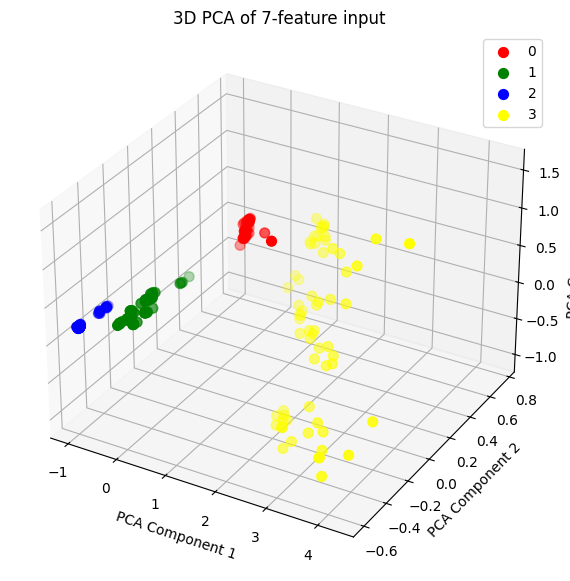

In [7]:
# sample visualization

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Plot in 3D
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# Assign a color to each label
unique_labels = np.unique(y)
colors = ['red', 'green', 'blue', 'yellow']  

for i, label in enumerate(unique_labels):
    idx = y == label
    ax.scatter(X_pca[idx, 0], X_pca[idx, 1], X_pca[idx, 2],
               label=str(label), color=colors[i], s=50)

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D PCA of 7-feature input')
ax.legend()
plt.show()

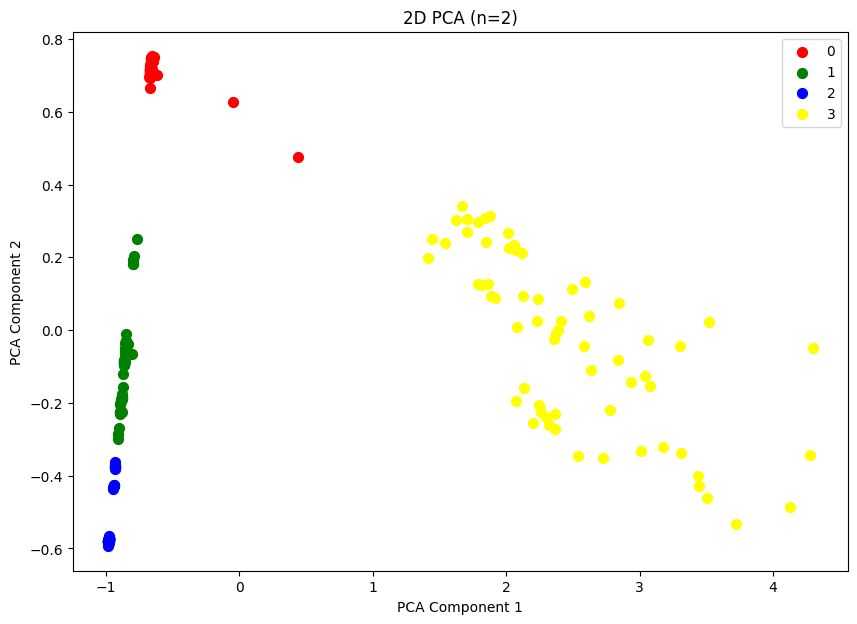

In [8]:
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X)

plt.figure(figsize=(10, 7))

for i, label in enumerate(unique_labels):
    idx = y == label
    plt.scatter(
        X_pca2[idx, 0], X_pca2[idx, 1],
        label=str(label), color=colors[i], s=50
    )

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA (n=2)')
plt.legend()
plt.show()

In [9]:
# scale data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(178, 7)
(39, 7)
(39, 7)


## Train Model

In [10]:
svm_classifier = SVC(kernel='linear', C=1, random_state=seed)
svm_classifier.fit(X_train_scaled, y_train)

# Save the model
with open("svm_model.pkl", "wb") as f:
    pickle.dump(svm_classifier, f)

print("SVM Weights (w):")
print(svm_classifier.coef_)

print("\nSVM Intercept (b):")
print(svm_classifier.intercept_)

SVM Weights (w):
[[ 0.62484723 -0.06391861 -1.31351221 -0.03073176 -0.09915479 -0.02026036
   0.0086784 ]
 [ 0.41752681 -0.28864039 -0.46327953 -0.03968791  0.05022713 -0.03706181
   0.04316406]
 [-0.01006903 -0.10128146 -0.07758408 -0.67799036  0.03572599 -0.4519603
  -0.64881238]
 [ 0.26063459 -1.14977794 -0.13814736 -0.02949741  0.00391127 -0.0050088
   0.02296067]
 [-0.16587986 -0.20960588  0.21998685 -0.31898428  0.11681968 -0.26366871
  -0.29875037]
 [-0.2351557   0.12406057  0.27490285 -0.23501229  0.00360866 -0.13164767
  -0.22226893]]

SVM Intercept (b):
[-0.75229682  0.15514468  0.6756937   0.87045532  0.24651809  0.04800456]


## Training and Validation

In [11]:
def display_results(ground_truth, prediction, title):
    print(f"========== {title} ==========")
    print(f"Accuracy: {accuracy_score(ground_truth, prediction):.2f}\n")
    print(classification_report(ground_truth, prediction))

    cm = confusion_matrix(ground_truth, prediction)
    print("Confusion Matrix:")
    print(cm, "\n")

y_pred_val = svm_classifier.predict(X_val_scaled)
y_pred_train = svm_classifier.predict(X_train_scaled)


display_results(y_val, y_pred_val, "Validation")
display_results(y_train, y_pred_train, "Training")

========== Validation ==========
Accuracy: 1.00

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39

Confusion Matrix:
[[ 9  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]] 

========== Training ==========
Accuracy: 1.00

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        43
           2       1.00      1.00      1.00        48
           3       1.00      1.00      1.00        44

    accuracy                           1.00       178
   macro avg       1.00      1.00      1.00       178
weighted

## Test Model

In [12]:
y_pred_test = svm_classifier.predict(X_test_scaled)

display_results(y_test, y_pred_test, "Testing")

========== Testing ==========
Accuracy: 1.00

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39

Confusion Matrix:
[[10  0  0  0]
 [ 0  9  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]] 

